In [1]:
import time
from typing import Optional, Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [2]:
torch.cuda.is_available()

True

In [12]:
torch.__version__

'1.13.1+cu117'

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root='../models/mnist',
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root='../models/mnist',
    train=False,
    transform=ToTensor(),
    download=True,
)

In [4]:
class TrainHelper:
    @staticmethod
    def train(cnn: nn.Module,
              *,
              epochs: int,
              train_dataset: datasets.MNIST,
              test_dataset: Optional[datasets.MNIST] = None,
              print_results: bool = True,
              batch_size: int,
              device_name: str) -> List[float]:

        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=1)

        device = torch.device(device_name)

        cnn.to(device)
        cnn.train()

        optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
        loss_func = nn.CrossEntropyLoss()

        eval_results: List[float] = []

        for epoch in range(epochs):
            for images, labels in train_loader:
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))

                output = cnn(images)
                loss = loss_func(output, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if test_dataset is not None:
                eval_result = TrainHelper.test(cnn, test_dataset, device)
                eval_results.append(eval_result)
                if print_results:
                    print(f"epoch {epoch}, accuracy = {eval_result}, loss = {loss.detach()}")
                cnn.train()

        return eval_results

    @staticmethod
    def test(cnn: nn.Module, test_dataset: datasets.MNIST, device=None) -> float:
        cnn.eval()
        loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=1)
        correct = 0
        incorrect = 0

        for images, labels in loader:
            if device is not None:
                images = images.to(device)

            results = cnn(images)
            predictions = results.detach().cpu().numpy().argmax(axis=1)
            oks = (predictions == labels.numpy()).sum()
            correct += oks
            incorrect += len(predictions) - oks

        return correct / (correct + incorrect)

    @staticmethod
    def train_models(models: List[nn.Module], device_name: str) -> Tuple[int, float]:
        """
        generator yields pair (trainable parameters count, best accuracy) for each network
        :param device_name: 'cuda' or 'cpu'
        """
        assert len(models) > 0

        for model in models:
            start = time.time()
            eval_results = TrainHelper.train(
                cnn=model,
                epochs=20,
                train_dataset=train_data,
                test_dataset=test_data,
                batch_size=2048,
                device_name=device_name,
                print_results=False
            )
            end = time.time()
            best_acc = max(eval_results)
            params_count = TrainHelper.total_parameters_count(model)
            print(f"best accuracy = {best_acc}, parameters = {params_count}, training time = {end - start}")
            yield params_count, best_acc

    @staticmethod
    def total_parameters_count(model: nn.Module) -> int:
        return sum(np.prod(p.size()) for p in model.parameters())

    @staticmethod
    def print_parameters(model: nn.Module):
        print(f"total parameters = {TrainHelper.total_parameters_count(model)}")
        for p in model.parameters():
            print(f"size {np.prod(p.size())}: {p.size()}")

In [8]:
class MyConvModel(nn.Module):
    def __init__(self, channels: int):
        super(MyConvModel, self).__init__()

        c = channels
        self.layers = nn.Sequential(
            self.conv(1, c, kernel_size=3),         # 28 - 26
            self.conv(c, c, kernel_size=3),         # 26 - 24
            nn.MaxPool2d(2),                        # 24 - 12

            self.conv(c, c * 2, kernel_size=3),     # 12 - 10
            self.conv(c * 2, c * 2, kernel_size=3), # 10 - 8
            nn.MaxPool2d(2),                        # 8 - 4

            self.conv(c * 2, c * 4, kernel_size=3), # 4 - 2
            self.conv(c * 4, c * 4, kernel_size=2), # 2 - 1

            nn.Conv2d(c * 4, 10, kernel_size=1, padding='valid', bias=True),
            nn.Flatten(),
        )

    def conv(self, in_ch: int, out_ch: int, *, kernel_size):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding='valid', bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1),
        )

    def forward(self, x: torch.Tensor):
        return self.layers(x)

In [9]:
results = []

In [10]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'

for i in range(4):
    models = [MyConvModel(n) for n in [4, 6, 8, 12, 16, 24, 32, 48, 64]]
    for pair in TrainHelper.train_models(models, device_name=device_name):
        results.append(pair)

best accuracy = 0.9859, parameters = 3502, training time = 85.59752869606018
best accuracy = 0.9916, parameters = 7636, training time = 83.71403670310974
best accuracy = 0.9918, parameters = 13362, training time = 84.40341186523438
best accuracy = 0.9933, parameters = 29590, training time = 85.25695300102234
best accuracy = 0.9951, parameters = 52186, training time = 85.53233933448792
best accuracy = 0.9947, parameters = 116482, training time = 85.77489805221558
best accuracy = 0.9946, parameters = 206250, training time = 85.78431439399719
best accuracy = 0.9956, parameters = 462202, training time = 87.11874127388
best accuracy = 0.9956, parameters = 820042, training time = 94.52858090400696
best accuracy = 0.9846, parameters = 3502, training time = 86.75645399093628
best accuracy = 0.9898, parameters = 7636, training time = 86.39272165298462
best accuracy = 0.9917, parameters = 13362, training time = 86.40437388420105
best accuracy = 0.9947, parameters = 29590, training time = 86.8859

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


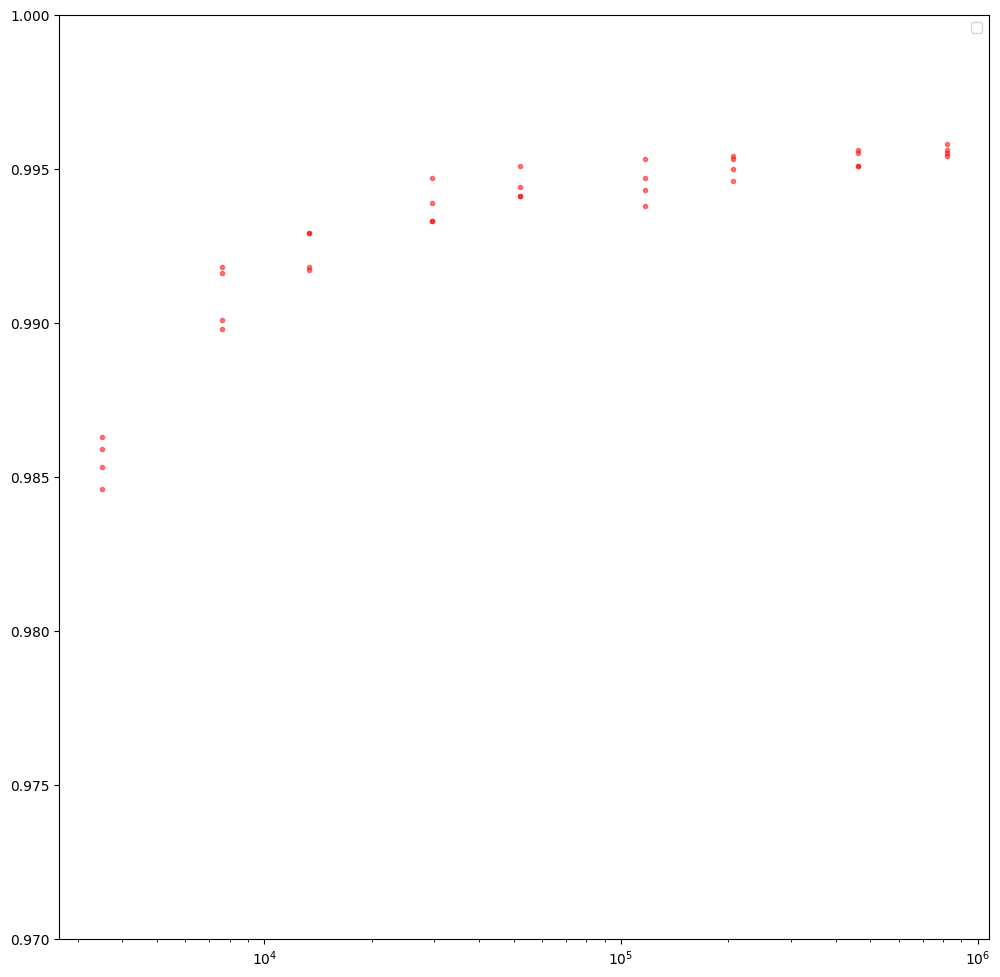

In [11]:
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_ylim(0.97, 1)

params_counts = [p[0] for p in results]
accuracies = [p[1] for p in results]

ax.scatter(params_counts, accuracies, c='red', alpha=0.5, marker=r'.')

ax.legend()
plt.show()